### Explosiveness Test

Explosiveness test는 일반적으로 하나의 거품을 테스트하는 것과 다수의 거품을 테스트하는 것으로 나뉜다. 이 맥락에서 거품들은 가격 폭등만을 의미하는 것이 아니라 가격 폭락 또한 포함한다. 다수의 거품을 테스트하는 것은 bubble-burst-bubble의 사이클이 단일 버블 테스트보다 더 정상성 시계열처럼 보이게 한다는 관점에서 보다 더 강건하다. Maddala and Kim(1998)과 Breitung(2014)의 논문에서 이에 대한 개관을 볼 수 있다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

START_DATE = '2000-01-01'
END_DATE = pd.to_datetime('today')
TICKER = '^GSPC'

data = yf.download(
    TICKER,
    start = START_DATE,
    end = END_DATE,
    interval = '1d',
    progress = False
)
data = data.resample('W').last()

#### 1. Chow-Type Dickey-Fuller Test

Explosiveness Test Class는 Chow(1960)에 의해 시작됐는데, 이는 그레고리 초의 업적에서 영감을 받은 것이다. 다음과 같은 $\text{AR}(1)$ process를 고려해 보자.

$$y_t = \rho y_{t-1} + \epsilon_t$$

여기서 $\epsilon_t$는 white noise이다. 귀무가설은 $y_t$가 random walk를 따른다는 것이다. 즉 $H_0 : \rho = 1$이다. 대립가설은 $y_t$가 random walk로 시작하지만, 시간 $\tau^* T$에서 다음의 폭발성 프로세스로 변한다는 것이다. 여기서 $\tau^* \in (0,1)$이다.

$$
H_1 : y_t=
\begin{cases}
y_{t-1} + \epsilon_t & \text{ for } t = 1, \dots, \tau^*T\\
\rho y_{t-1} + \epsilon_t & \text{ for } t = \tau^*T + 1, \dots, T \text{ where } \rho > 1
\end{cases}
$$

시점 $T$에서 국면 전환이 $\tau^* T$(발생일)에서 발생했는지 테스트할 수 있다. 이 가정을 테스트하려면 다음을 적합화해야 한다.

$$\Delta y_t = \delta y_{t-1} D_t[\tau^*] + \epsilon_t$$

여기서 $ D_t[\tau^*]$는 가변수로, $t < \tau ^* T$이면 0이고, $t \geq \tau ^* T$이면 1이다. 그러면 귀무가설 $H_0 : \delta = 0$은 대립가설 $H_1 : \delta > 1$에 대해 테스트한다.

$$\text{DFC}_{\tau^*} = \frac{\hat{\delta}}{\hat{\sigma}_\delta}$$

이 기법의 주요 단점은 $\tau^*$을 알 수 없다는 것이다. Andrews(1993)는 이 문제를 해결하고자 $\tau^* \in [\tau_0, 1-\tau_0]$구간 내의 모든 가능한 $\tau^*$에 대해 테스트해 보는 새로운 검정 방법을 제시했다. Breitung(2014)의 논문에서 설명한 것처럼 샘풀의 최초와 마지막의 가능한 $\tau^*$를 일부 남겨서 각 국면이 충분한 관측값으로 적합화되도록 보장해야 한다. 미지의 $\tau^*$에 대한 검정 통계량은 $\text{DFC}_{\tau^*}$의 모든 $T(1-2\tau_0)$값 중 최대값이다. 

$$\text{SDFC} = \sup_{\tau^* \in [\tau_0, 1 - \tau_0]} \left\{ \text{DFC}_{\tau^*}\right\}$$

In [2]:
from FinancialMachineLearning.regime_change.chow_type import chow_type_stat

chow = chow_type_stat(
    series = data['Close'].pct_change(), 
    min_length = 20, 
    num_threads = 8
)

2024-08-02 22:00:30.854621 100.0% chow_type_adf done after 0.03 minutes. Remaining 0.0 minutes.


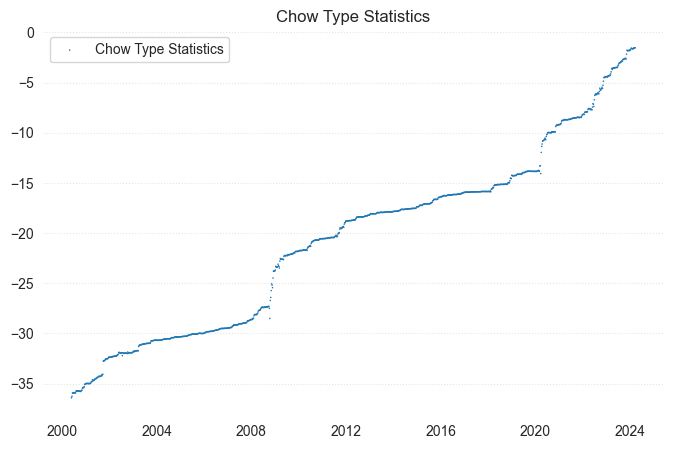

In [3]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    chow.index,
    chow,
    label = 'Chow Type Statistics',
    edgecolor = 'none',
    marker = '.',
    s = 5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Chow Type Statistics')
plt.show()

Chow의 방법에서 또 다른 문제점은 오직 하나의 발생일 $\tau^* T$가 있어서 버블이 샘플 마지막까지 지속된다는 것이다. 3개 이상의 국면이 존재하는 상황에서 Supremum Aumented Dickey-Fuller를 논의해야 한다.

#### 2. Supremum Augmented Dickey-Fuller Test

Phillips, Wu & Yu(2011)은 다음과 같이 말했다.

> 표준 단위근과 공적분 테스트는 정상성 프로세스와 주기적 붕괴 버블 모형을 효과적으로 구분하지 못하기 때문에 버블을 탐지하는 도구로서 적절하지 못하다. 데이터에서 주기적으로 붕괴하는 패턴들은 잠재적으로 폭발하는 프로세스보다는 단위근이 정상성 자기회귀로부터 생성된 데이터처럼 보인다

이 결함을 해결하고자 Phillips, Wu & Yu는 다음 설정의 회귀식을 적합화할것을 제안한다.

$$\Delta y_t = \alpha + \beta y_{t-1} + \sum_{l=1}^L \gamma_l \Delta y_{t-l} + \epsilon_t$$

여기서 $H_0 : \beta \leq 0, H_1 : \beta > 0$을 테스트한다. Phillips, Yu(2011) 그리고 Phillips, Wu & Yu(2011)는 Andrews(1993)의 논문에서 영감을 받아 Supremum Aumented Dickey-Fuller 검정을 제안했다. SADF는 앞의 회귀식을 각 마지막 시점 T에서 역방향 확장 시작 시점들로 적합화한 후 다음을 계산했다.

$$\text{SADF}_t = \sup_{t_0 \in [1, t-\tau]} \left\{ \text{ADF}_{t_0, t}\right\} = \sup_{t_0 \in [1, t-\tau]} \left\{ \frac{\hat{\beta}_{t_0, t}}{\hat{\sigma}_{\beta_{t_0, t}}}\right\}$$

여기서 $\hat{\beta}_{t_0, t}$는 $t_0$에서 시작해 $t$에서 끝나는 샘플에서 계산하고, $\tau$는 분석에 사용되는 최소 표본 길이, $t_0$은 역방향 확장 윈도우의 왼쪽 경계이고 $t = \tau, \dots, T$이다. $\text{SADF}_t$를 계산하기 위해서는 윈도우의 오른쪽 부분이 $t$에서 고정된다. 표준 $\text{ADF}$검정은 $\text{SADF}_t$의 특수한 경우이다. 여기서 $\tau = t-1$이다. $\text{SADF}_t$와 $\text{SDFC}$는 두 가지 중요한 차이가 있다. 첫째, $\text{SADF}_t$는 각 $\tau \in [\tau, T]$에서 계산되지만, $\text{SDFC}$는 $T$에서만 계산된다. 둘째, 가변수를 쓰는 대신 $\text{SADF}$를 재귀적으로 표본의 시작을 확장한다. $\text{SADF}_t$는 중첩된 이중 루프틑 $(t_0, t)$의 모든 조합에 대해 시행함으로써 국면 전환의 개수나 발생일이 알려져 있다고 가정하지 않는다. 

In [7]:
from FinancialMachineLearning.regime_change.supremum_adf import get_sadf

sadf = get_sadf(
    series = np.log(data['Close']), 
    model = 'linear', 
    lags = 3, 
    min_length = 20, 
    add_const = True,
    num_threads = 8
)

2024-08-02 12:31:52.273303 100.0% sadf_outer_loop done after 0.08 minutes. Remaining 0.0 minutes.


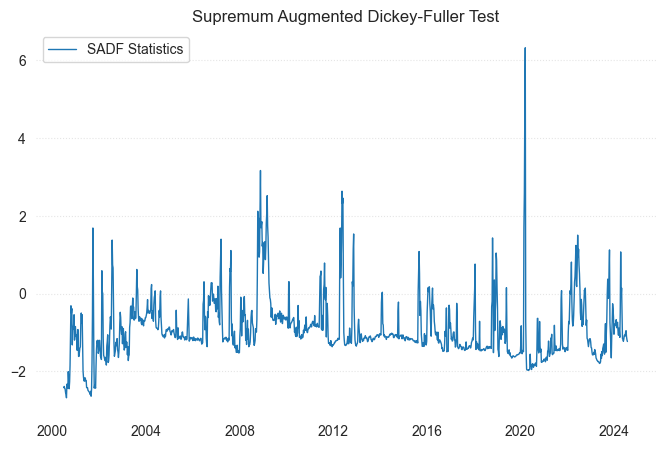

In [10]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    sadf,
    label = 'SADF Statistics',
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Supremum Augmented Dickey-Fuller Test')
plt.show()

#### Super Martingale Test

In [12]:
sadf_quad = get_sadf(
    series = np.log(data['Close']), 
    model = 'quadratic', 
    lags = 3, 
    min_length = 20, 
    add_const = True,
    num_threads = 8
)

2024-08-02 12:50:36.907914 100.0% sadf_outer_loop done after 0.08 minutes. Remaining 0.0 minutes.


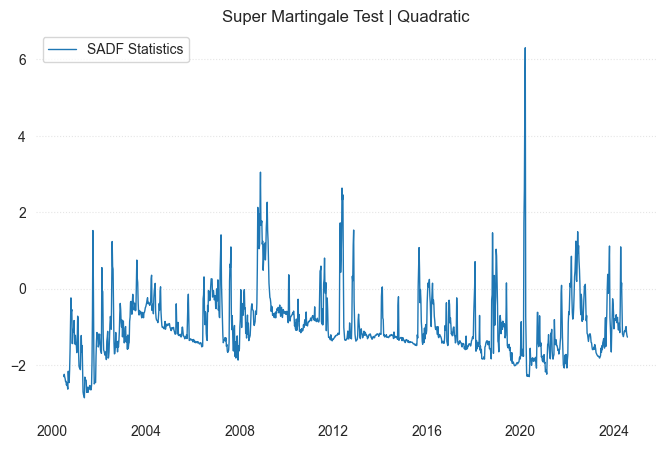

In [14]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    sadf_quad,
    label = 'SADF Statistics',
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Super Martingale Test | Quadratic')
plt.show()

In [15]:
sadf_poly1 = get_sadf(
    series = np.log(data['Close']), 
    model = 'sm_poly_1', 
    lags = 3, 
    min_length = 20, 
    add_const = True,
    num_threads = 8
)

2024-08-02 12:51:31.375720 100.0% sadf_outer_loop done after 0.06 minutes. Remaining 0.0 minutes.


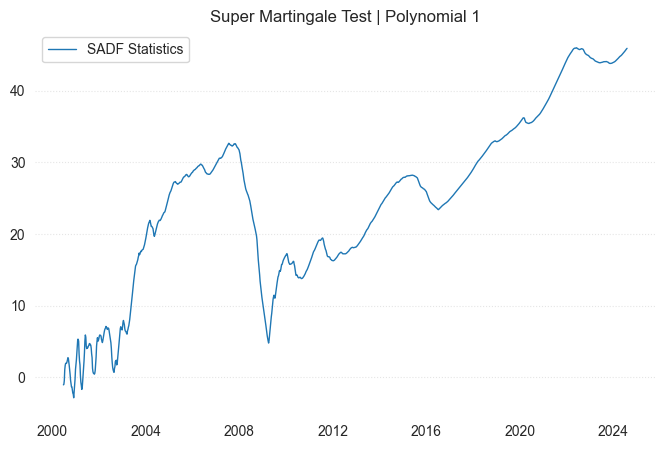

In [16]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    sadf_poly1,
    label = 'SADF Statistics',
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Super Martingale Test | Polynomial 1')
plt.show()

In [17]:
sadf_poly2 = get_sadf(
    series = np.log(data['Close']), 
    model = 'sm_poly_2', 
    lags = 3, 
    min_length = 20, 
    add_const = True,
    num_threads = 8
)

2024-08-02 12:52:08.512603 100.0% sadf_outer_loop done after 0.06 minutes. Remaining 0.0 minutes.


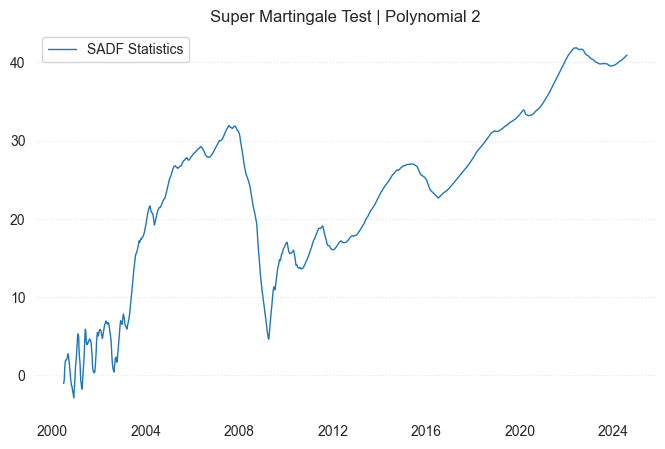

In [18]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    sadf_poly2,
    label = 'SADF Statistics',
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Super Martingale Test | Polynomial 2')
plt.show()

In [19]:
sadf_exp = get_sadf(
    series = np.log(data['Close']), 
    model = 'sm_exp', 
    lags = 3, 
    min_length = 20, 
    add_const = True,
    num_threads = 8
)

2024-08-02 12:52:42.074708 100.0% sadf_outer_loop done after 0.05 minutes. Remaining 0.0 minutes.


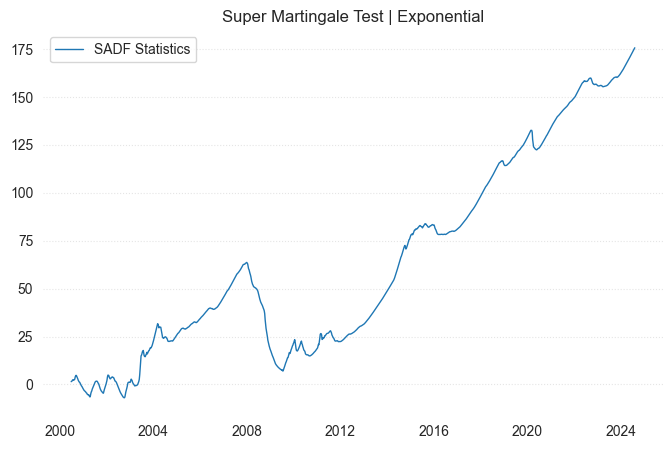

In [20]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    sadf_exp,
    label = 'SADF Statistics',
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Super Martingale Test | Exponential')
plt.show()

In [21]:
sadf_pow = get_sadf(
    series = np.log(data['Close']), 
    model = 'sm_power', 
    lags = 3, 
    min_length = 20, 
    add_const = True,
    num_threads = 8
)

C:\Users\USER\PycharmProjects\MLFinance\FinancialMachineLearning\regime_change\supremum_adf.py:59: RuntimeWarning: divide by zero encountered in log
  x['log_trend'] = np.log(np.arange(x.shape[0]))
2024-08-02 12:53:13.489496 100.0% sadf_outer_loop done after 0.06 minutes. Remaining 0.0 minutes.


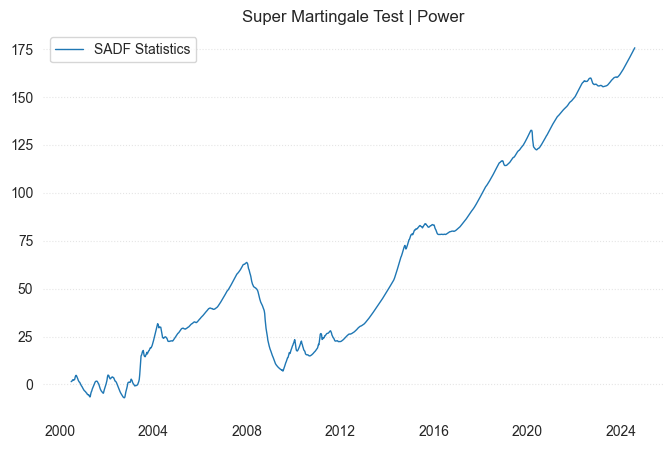

In [22]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(
    sadf_exp,
    label = 'SADF Statistics',
    lw = 1
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.legend()
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Super Martingale Test | Power')
plt.show()